In [2]:
import sys
import os

parent_dir = os.path.abspath(os.path.join(os.path.dirname('__file__'), '..'))
sys.path.insert(0, parent_dir)


import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import invgamma
import utils

import hashlib
from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture
from mixtureModels import DiagGaussianFS
from sklearn.metrics.cluster import adjusted_rand_score
import time
import pandas as pd
import multiprocessing

## Dataset Generation

In [4]:
N = 1000
K = 3
D = 5

# seed = 4132
seed = np.random.randint(1000, 2**16)
seed = 22367
np.random.seed(seed)

print(seed)

N_noisey_features = 0
data_dir = "thesisResData"
filenames = []

if not data_dir in os.listdir():
    os.mkdir(data_dir)

m0_true = np.random.uniform(2, 8, (K, D))
k0_true = np.random.uniform(1, 1.5, K)
S0_true = np.random.uniform(0, 2, (K , D))
v0_true = np.random.randint(1, 5, K)

alpha_true = 1.0

mu = np.zeros((K, D), float)
sigma = np.zeros((K, D), float)
for k in range(K):
    for j in range(D):
        mu[k, j] = norm.rvs(m0_true[k, j], S0_true[k, j]/(k0_true[k]*v0_true[k]))
        sigma[k, j] = invgamma.rvs(v0_true[k]/2, S0_true[k, j]/2)

mixing_probabilities = np.random.dirichlet([alpha_true]*K, size=1)[0]
z_true = np.random.choice(K, p=mixing_probabilities, size=N)

X = np.zeros((N, D))

for i in range(N):
    for j in range(D):
        for k in range(K):
            if z_true[i] == k:
                X[i, j] = np.random.normal(mu[k, j], sigma[k, j])

for i_feature in range(N_noisey_features+1):

    isLOCAL = False # global or local
    true_features = np.ones((K, D+i_feature), int)
    
    if not isLOCAL:
        true_features[:, :i_feature] = np.zeros((K, i_feature), int)
    else:
        for j in range(i_feature):
            rand_cluster = np.random.randint(0, 2, K)
            true_features[:, j] = rand_cluster
    
    X_noisey = np.concatenate((np.zeros((N, i_feature)), X.copy()), axis = 1)
    
    X_mean = np.mean(X)
    X_var = np.var(X)
    for k in range(K):
        for j in range(D+i_feature):
            if true_features[k][j] == 0:
                for i in range(N):
                    if z_true[i] == k:
                        X_noisey[i, j] = np.random.normal(X_mean, 3*X_var)
    

    filename = f"{N}_{K}_{D}_{seed}_{hashlib.sha256(X_noisey.tobytes()).hexdigest()[:5]}_{i_feature}"
    filenames.append(filename)
    
    filepath = f"{data_dir}/{filename}"
    print(utils.saveData(f"{filepath}.csv", X_noisey, remark="Data"))
    print(utils.saveData(f"{filepath}.labels", z_true, remark="Labels"))


22367
thesisResData/1000_3_5_22367_071da_0.csv
thesisResData/1000_3_5_22367_071da_0.labels


In [ ]:
# for filename in filenames:
#     X = utils.extractData(f"{data_dir}/{filename}.csv", "data")
#     # print(filename)
#     # print(X[0])
#     # heatmap = sns.heatmap(X[np.argsort(z_true)])
#     plt.show()
#     plt.close()

## Models

In [ ]:
## Run scikit GMM with no noisy data

def runEM(filename):
    
    print(f"\n{filename}")

    start_time = time.process_time()
    training_runs_EM = 2
    EM_gmm = GaussianMixture(n_components=K, n_init=training_runs_EM)
    X = utils.extractData(f"{data_dir}/{filename}.csv", "data")
    EM_gmm.fit(X)
    
    print(f"BIC: {EM_gmm.bic(X)}\nK: {K}")
    z_pred_EM = EM_gmm.predict(X)
    utils.saveData(f"out{data_dir}/{filename}.pred.em.labels", z_pred_EM, "labels")
    utils.saveData(f"out{data_dir}/{filename}.pred.em.time", time.process_time() - start_time, "single")



def runBayes(filename):

    print(f"\n{filename}")

    start_time = time.process_time()
    X = utils.extractData(f"{data_dir}/{filename}.csv", "data")
    est = DiagGaussianFS(alpha = 1.0, m_0_partial = 0, k_0 = 0.03, v_0_partial = 3, S_0_partial = 0.3, K_initial = K, iterations=30, runs = 2)
    est.sample(X)
    bayes_pred = est.assignments()
    utils.saveData(f"out{data_dir}/{filename}.pred.bayes.labels", bayes_pred, "labels")
    utils.saveData(f"out{data_dir}/{filename}.pred.bayes.time", time.process_time() - start_time, "single")
    


def runBayesFS(filename):

    print(f"\n{filename}")

    start_time = time.process_time()
    X = utils.extractData(f"{data_dir}/{filename}.csv", "data")
    est = DiagGaussianFS(alpha = 1.0, m_0_partial = 0, k_0 = 0.03, v_0_partial = 3, S_0_partial = 0.3, K_initial = K, iterations=30, runs = 2, FS=True)
    est.sample(X)
    bayes_pred_FS = est.assignments()
    utils.saveData(f"out{data_dir}/{filename}.pred.bayes.fs.labels", bayes_pred_FS, "labels")
    utils.saveData(f"out{data_dir}/{filename}.pred.bayes.fs.time", time.process_time() - start_time, "single")

#####################

def runEM_diag(filename):
    
    print(f"\n{filename}")

    start_time = time.process_time()
    training_runs_EM = 2
    EM_gmm = GaussianMixture(n_components=K, n_init=training_runs_EM, covariance_type = "diag")
    X = utils.extractData(f"{data_dir}/{filename}.csv", "data")
    EM_gmm.fit(X)
    
    print(f"BIC: {EM_gmm.bic(X)}\nK: {K}")
    z_pred_EM = EM_gmm.predict(X)
    utils.saveData(f"out{data_dir}/{filename}.pred.em_diag.labels", z_pred_EM, "labels")
    utils.saveData(f"out{data_dir}/{filename}.pred.em_diag.time", time.process_time() - start_time, "single")



def runBayesUnknownK(filename):

    print(f"\n{filename}")

    start_time = time.process_time()
    X = utils.extractData(f"{data_dir}/{filename}.csv", "data")
    est = DiagGaussianFS(alpha = 1.0, m_0_partial = 0, k_0 = 0.03, v_0_partial = 3, K_initial = 20, S_0_partial = 0.3, iterations=30, runs = 2)
    est.sample(X)
    bayes_pred = est.assignments()
    utils.saveData(f"out{data_dir}/{filename}.pred.bayes_unknown_K.labels", bayes_pred, "labels")
    utils.saveData(f"out{data_dir}/{filename}.pred.bayes_unknown_K.time", time.process_time() - start_time, "single")
    

def runScikitBlah(filename):
    
    print(f"\n{filename}")

    start_time = time.process_time()
    X = utils.extractData(f"{data_dir}/{filename}.csv", "data")
    est = BayesianGaussianMixture(n_init = 2, n_components = K, covariance_type="diag", mean_precision_prior = 0.03, degrees_of_freedom_prior = 3 + len(X[0]), verbose=1 )
    # est = DiagGaussianFS(alpha = 1.0, m_0_partial = 0, k_0 = 0.03, v_0_partial = 3, S_0_partial = 0.3, K_initial = K, iterations=30, runs = 2)
    est.fit(X)
    bayes_pred = est.predict(X)
    utils.saveData(f"out{data_dir}/{filename}.pred.scikit.labels", bayes_pred, "labels")
    utils.saveData(f"out{data_dir}/{filename}.pred.scikit.time", time.process_time() - start_time, "single")


def runEMUnknownK(filename):

    print(f"\n{filename}")

    start_time = time.process_time()
    training_runs_EM = 2

    best_BIC = np.inf
    X = utils.extractData(f"{data_dir}/{filename}.csv", "data")
    for K in range(2, 21):
        EM_gmm = GaussianMixture(n_components=K, n_init=training_runs_EM)
        EM_gmm.fit(X)
        gmm_BIC = EM_gmm.bic(X)
        # print(f"BIC: {gmm_BIC} K: {K}")
        
        if gmm_BIC < best_BIC:
            best_BIC = gmm_BIC
            best_gmm = EM_gmm
    
    z_pred_EM_unknownK = best_gmm.predict(X)
    print(f"Best BIC: {best_BIC} K: {len(set(z_pred_EM_unknownK))}")

    
    utils.saveData(f"out{data_dir}/{filename}.pred.em_unknown_K.labels", z_pred_EM_unknownK, "labels")
    utils.saveData(f"out{data_dir}/{filename}.pred.em_unknown_K.time", time.process_time() - start_time, "single")


## Run models

In [14]:
def process_file(filename):
    # runEM(filename)
    # runBayes(filename)
    # runBayesFS(filename)
    runEm_diag(filename)
    runBayesUnknownK(filename)
    # runScikitBlah(filename)
    runEMUnknownK(filename)
    # runEM_diag(filename)    


if __name__ == "__main__":
    # filenames_parallel = [filenames[i] for i in range(0, 100, 10)] 
    # filenames_parallel = [filenames[i] for i in range(10)] 
    for filename in filenames:
        # runEM(filename)
        # runBayes(filename)
        # runBayesFS(filename)
        # runEm_diag(filename)
        # runBayesUnknownK(filename)
        # runScikitBlah(filename)
        runEMUnknownK(filename)
        # runEM_diag(filename) 
        
    # pool = multiprocessing.Pool()
    # pool.map(process_file, filenames_parallel)

    # pool.close()
    # pool.join()


1000_3_5_22367_071da_0
Best BIC: 23608.510065683247 K: 3

1000_3_5_22367_994d6_1
Best BIC: 33602.74947833067 K: 3

1000_3_5_22367_db1ba_2
Best BIC: 43612.56395854458 K: 3

1000_3_5_22367_aee48_3
Best BIC: 53589.900288269215 K: 3

1000_3_5_22367_6a5f4_4
Best BIC: 63574.37622559638 K: 3

1000_3_5_22367_a9209_5
Best BIC: 73677.07355906344 K: 2

1000_3_5_22367_b96ce_6
Best BIC: 83806.80470587766 K: 2

1000_3_5_22367_8ada7_7
Best BIC: 93685.95811134929 K: 2

1000_3_5_22367_77007_8
Best BIC: 103808.95888197435 K: 2

1000_3_5_22367_8f369_9
Best BIC: 113746.75053962317 K: 2

1000_3_5_22367_c66c7_10
Best BIC: 124004.2911847957 K: 2

1000_3_5_22367_d28ce_11
Best BIC: 133951.4025960891 K: 2

1000_3_5_22367_0d7f5_12
Best BIC: 143970.33606326074 K: 2

1000_3_5_22367_d1f9d_13
Best BIC: 154078.66297779948 K: 2

1000_3_5_22367_34c83_14
Best BIC: 164492.83209759183 K: 2

1000_3_5_22367_25618_15
Best BIC: 174631.27942648603 K: 2

1000_3_5_22367_8b770_16
Best BIC: 184392.2541485556 K: 2

1000_3_5_22367_

In [5]:
len(filenames)

101

In [16]:
times = {"EM":[], "bayes":[], "bayesFS":[], "EM_diag":[], "bayesUnknownK":[], "scikitBlah":[], "EMUnknownK":[]}
labels = {"EM":[], "bayes":[], "bayesFS":[], "EM_diag":[], "bayesUnknownK":[], "scikitBlah":[], "EMUnknownK":[]}

for filename in filenames:
    times["EM"].append(round(float(utils.extractData(f"out{data_dir}/{filename}.pred.em.time", "single")), 3))
    times["bayes"].append(round(float(utils.extractData(f"out{data_dir}/{filename}.pred.bayes.time", "single")), 3))
    times["bayesFS"].append(round(float(utils.extractData(f"out{data_dir}/{filename}.pred.bayes.fs.time", "single")), 3))
    times["EM_diag"].append(round(float(utils.extractData(f"out{data_dir}/{filename}.pred.em_diag.time", "single")), 3))
    times["bayesUnknownK"].append(round(float(utils.extractData(f"out{data_dir}/{filename}.pred.bayes_unknown_K.time", "single")), 3))
    times["scikitBlah"].append(round(float(utils.extractData(f"out{data_dir}/{filename}.pred.scikit.time", "single")), 3))
    times["EMUnknownK"].append(round(float(utils.extractData(f"out{data_dir}/{filename}.pred.em_unknown_K.time", "single")), 3))
    
    
    labels["EM"].append(utils.extractData(f"out{data_dir}/{filename}.pred.em.labels", "labels"))
    labels["bayes"].append(utils.extractData(f"out{data_dir}/{filename}.pred.bayes.labels", "labels"))
    labels["bayesFS"].append(utils.extractData(f"out{data_dir}/{filename}.pred.bayes.fs.labels", "labels"))
    labels["EM_diag"].append(utils.extractData(f"out{data_dir}/{filename}.pred.em_diag.labels", "labels"))
    labels["bayesUnknownK"].append(utils.extractData(f"out{data_dir}/{filename}.pred.bayes_unknown_K.labels", "labels"))
    labels["scikitBlah"].append(utils.extractData(f"out{data_dir}/{filename}.pred.scikit.labels", "labels"))
    labels["EMUnknownK"].append(utils.extractData(f"out{data_dir}/{filename}.pred.em_unknown_K.labels", "labels"))
    

In [17]:
ari = {"EM":[], "bayes":[], "bayesFS":[], "EM_diag":[], "bayesUnknownK":[], "scikitBlah":[], "EMUnknownK":[]}
process_time = {"EM":[], "bayes":[], "bayesFS":[], "EM_diag":[], "bayesUnknownK":[], "scikitBlah":[], "EMUnknownK":[]}

for key in labels:
    for z in labels[key]:
        ari[key].append(round(adjusted_rand_score(z_true, z), 3))

for key in times:
    for t in times[key]:
        process_time[key].append(t)

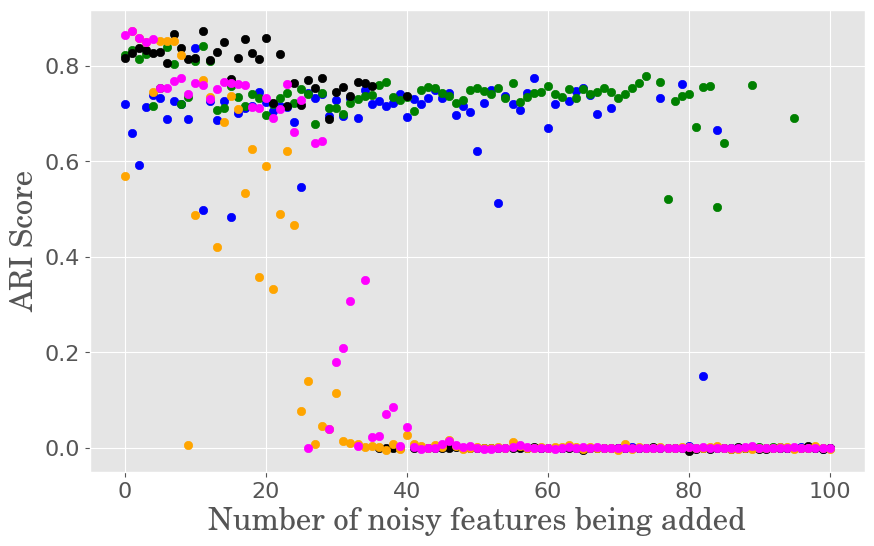

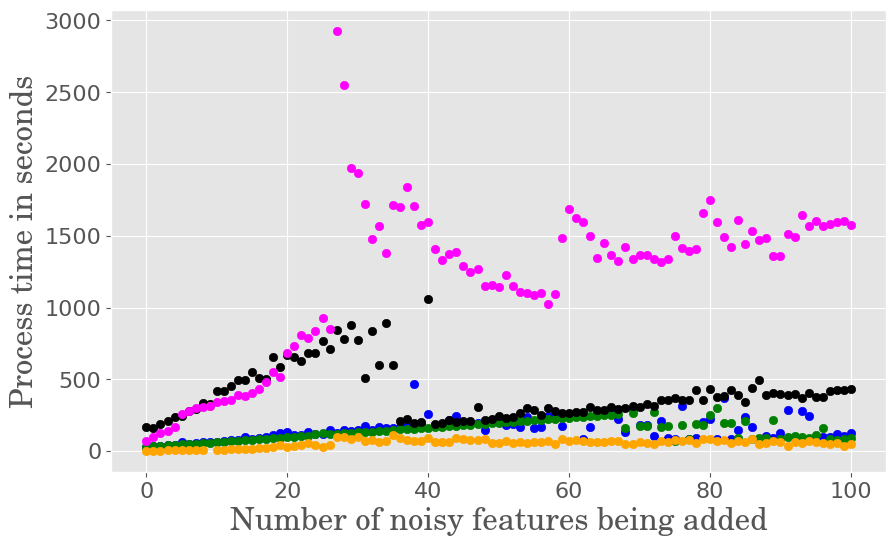

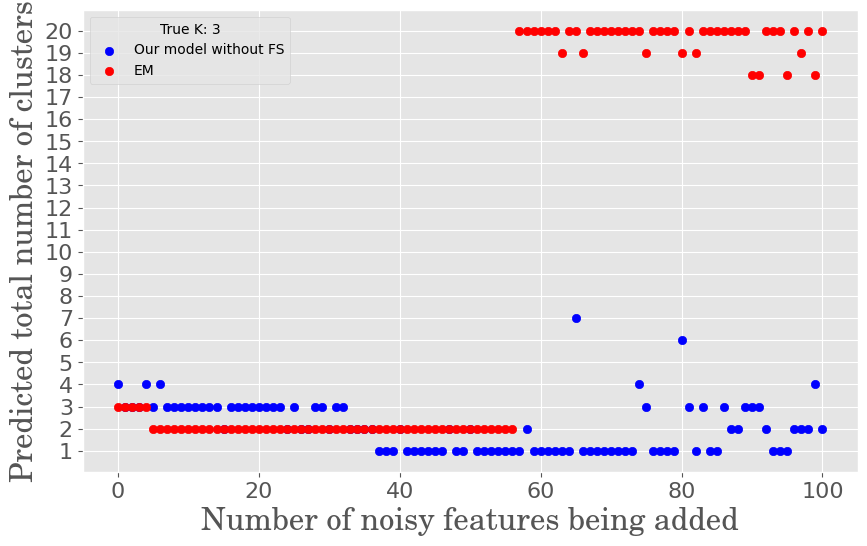

In [20]:
x_indices = np.arange(len(ari['EM']))
fig, ax = plt.subplots(figsize=(10, 6))
plt.style.use('ggplot')
ax.scatter(x_indices, ari['bayesFS'], color='#0000FF', label='Our model without Feature selection (Known K)')
ax.scatter(x_indices, ari['bayes'], color='#008000', label='Our model with Feature Selection (Known K)')
ax.scatter(x_indices, ari['bayesUnknownK'], color='black', label='Our model without Feature selection (Unknown K)')
ax.scatter(x_indices, ari["EM"], color='#FFA500', label='EM with Scikit GMM (Known K)')
# ax.scatter(x_indices, process_time['scikitBlah'], color='#00FFFF', label='Scikit: 2 runs')
ax.scatter(x_indices, ari['EMUnknownK'], color='#FF00FF', label='EM with Scikit GMM (Unknown K)')
ax.set_xlabel(f"Number of noisy features being added",    fontdict={'fontsize': 22, 'fontfamily': 'C059'})
ax.set_ylabel('ARI Score',    fontdict={'fontsize': 22, 'fontfamily': 'C059'})
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# ax.set_title(f'Comparing ARI scores for N:{N} D:{D} K:{K}')
# ax.legend()
plt.savefig('thesis-results/gauss_with_noise_scatter_ari.png', dpi=200)
plt.show()
plt.close()



fig, ax = plt.subplots(figsize=(10, 6))
plt.style.use('ggplot')
# ax.scatter(x_indices, process_time["EM"], color='#FF0000', label='EM: 2 runs')
ax.scatter(x_indices, process_time['bayesFS'], color='#0000FF', label='Our model without Feature selection (Known K)')
ax.scatter(x_indices, process_time['bayes'], color='#008000', label='Our model with Feature Selection (Known K)')
ax.scatter(x_indices, process_time['bayesUnknownK'], color='black', label='Our model without Feature selection (Unknown K)')
ax.scatter(x_indices, process_time["EM"], color='#FFA500', label='EM with Scikit GMM (Known K)')
# ax.scatter(x_indices, process_time['scikitBlah'], color='#00FFFF', label='Scikit: 2 runs')
ax.scatter(x_indices, process_time['EMUnknownK'], color='#FF00FF', label='EM with Scikit GMM (Unknown K)')
ax.set_xlabel(f"Number of noisy features being added",   fontdict={'fontsize': 22, 'fontfamily': 'C059'})
ax.set_ylabel('Process time in seconds',   fontdict={'fontsize': 22, 'fontfamily': 'C059'})
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# ax.set_title(f'Comparing Runtimes for N:{N} D:{D} K:{K}')
# ax.legend()
plt.savefig('thesis-results/gauss_with_noise_scatter_time.png', dpi=200)
plt.show()
plt.close()


fig, ax = plt.subplots(figsize=(10, 6))
plt.style.use('ggplot')
ax.scatter(x_indices, [len(set(label)) for label in labels['bayesUnknownK']], color='#0000FF', label='Our model without FS')
ax.scatter(x_indices, [len(set(label)) for label in  labels['EMUnknownK']], color='#FF0000', label='EM')
ax.set_xlabel(f"Number of noisy features being added", fontdict={'fontsize': 22, 'fontfamily': 'C059'})
ax.set_ylabel(f'Predicted total number of clusters', fontdict={'fontsize': 22, 'fontfamily': 'C059'})
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.yticks(range(1, 21))
# ax.set_title(f'Comparing predicted K for N:{N} D:{D} K:{K}')
ax.legend(title = f"True K: {K}")

plt.savefig('thesis-results/gauss_with_noise_scatter_predicted_K.png', dpi=200)
plt.show()
plt.close()



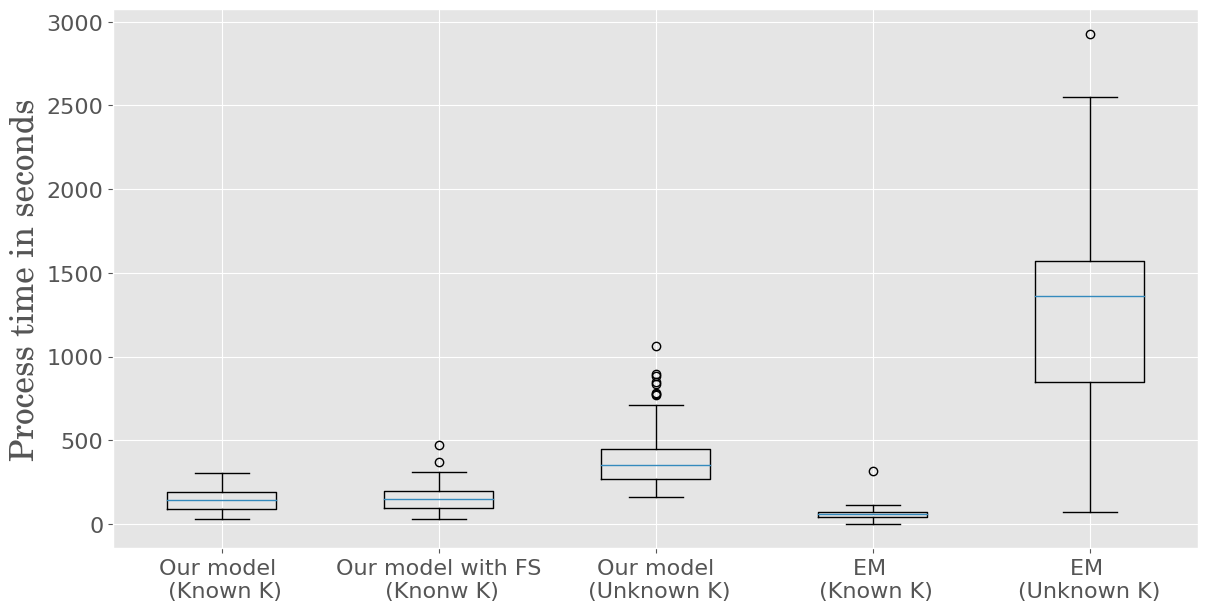

In [13]:
# data = [[len(set(label)) for label in labels['bayesUnknownK']], [len(set(label)) for label in labels['EMUnknownK']]]
# dataDF = pd.DataFrame(ari)
# plt.figure(figsize=(10, 6))
# plt.style.use('ggplot')
# labels_box=['Bayes (Unknown K)', 'EM (Unknown K)']
# plt.boxplot(data, labels = labels_box)
# # dataDF.boxplot(column=['bayes', 'bayesFS', 'bayesUnknownK', 'EM_diag', "EMUnknownK"])
# # plt.title(f'ARI Comparison of Models for  N:{N} D:{D} K:{K}')
# plt.ylabel(f'Predicted total number of clusters', fontdict={'fontsize': 14, 'fontfamily': 'C059'})
# plt.xlabel('Models', fontdict={'fontsize': 14, 'fontfamily': 'C059'})


# plt.savefig('thesis-results/gauss_with_noise_boxplot_ari.png', dpi=300)
# plt.show()
# plt.close()



# # print(len(ari['EM']), len(ari['bayes']), len(ari['scikitBlah']))
# # data = [ari['EM'], ari['bayes'], ari['scikitBlah'], ari['bayesFS'], ari['bayesUnknownK'], ari['EM_diag'], ari['EMUnknownK']]
# data = [ari['bayesFS'], ari['bayes'],  ari['bayesUnknownK'], ari['EM'], ari['EMUnknownK']]
# dataDF = pd.DataFrame(ari)
# plt.figure(figsize=(10, 6))
# plt.style.use('ggplot')
# labels_box=['Bayes', 'Bayes with FS', 'Bayes (Unknown K)', 'EM', 'EM (Unknown K)']
# plt.boxplot(data, labels = labels_box)
# # dataDF.boxplot(column=['bayes', 'bayesFS', 'bayesUnknownK', 'EM_diag', "EMUnknownK"])
# # plt.title(f'ARI Comparison of Models for  N:{N} D:{D} K:{K}')
# plt.ylabel('ARI Score', fontdict={'fontsize': 14, 'fontfamily': 'C059'})
# plt.xlabel('Models', fontdict={'fontsize': 14, 'fontfamily': 'C059'})
# plt.savefig('thesis-results/gauss_with_noise_boxplot_ari.png', dpi=300)
# plt.show()
# plt.close()



data = [ process_time['bayes'], process_time['bayesFS'], process_time['bayesUnknownK'], process_time['EM'], process_time['EMUnknownK']]
dataDF = pd.DataFrame(process_time)
plt.figure(figsize=(14, 7))
plt.style.use('ggplot')

labels_box=['Our model \n (Known K)', 'Our model with FS\n (Knonw K)', 'Our model\n (Unknown K)', 'EM \n (Known K)', 'EM \n(Unknown K)']
plt.boxplot(data, labels = labels_box )
# plt.title(f"Runtime comparison of Models for  N:{N} D:{D} K:{K}")
plt.ylabel('Process time in seconds', fontdict={'fontsize': 24, 'fontfamily': 'C059'})
plt.xlabel('', fontdict={'fontsize': 24, 'fontfamily': 'C059'})
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('thesis-results/gauss_with_noise_boxplot_time.png', dpi=200)
plt.show()
plt.close()


ath, string_to_check)


In [7]:
##### Empty the model's data results directory with other results #######
###### USE CATIOUSLY ########

# import os

# def delete_files_without_string(directory, target_string):
#     for filename in os.listdir(directory):
#         if target_string not in filename:
#             file_path = os.path.join(directory, filename)
#             os.remove(file_path)
#             print(f"Deleted file: {file_path}")

# delete_files_without_string(f"out{data_dir}", str(seed))